In [1]:
%pip install transformer_lens
%pip install plotly
%pip install seaborn
%pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 152.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"


print(f"Device: {device}")

torch.set_grad_enabled(False)

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import circuitsvis as cv
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

Device: cuda


In [3]:
import os
model = HookedTransformer.from_pretrained('gemma-2b')

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


In [4]:
import datasets
import sentencepiece as spm

## Load GSM8K dataset

In [5]:
gsm8k = datasets.load_dataset("gsm8k", "main", cache_dir='/tmp')
gsm8k_train, gsm8k_test = gsm8k['train'], gsm8k['test']

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [6]:
# @title Testing library
import re

def find_numbers(x: str) -> list[str]:
  """Finds all numbers in a string."""
  # Search for number, possibly negative (hyphen), with thousand separators
  # (comma), and with a decimal point (period inbetween digits).
  numbers = re.compile(
      r'-?[\d,]*\.?\d+',
      re.MULTILINE | re.DOTALL | re.IGNORECASE,
  ).findall(x)
  return numbers


def find_number(x: str,
                answer_delimiter: str = 'The answer is') -> str:
  """Finds the most relevant number in a string."""
  # If model uses the answer delimiter, then select the first number following
  # that format.
  if answer_delimiter in x:
    answer = x.split(answer_delimiter)[-1]
    numbers = find_numbers(answer)
    if numbers:
      return numbers[0]

  # In general, select the last number in the string.
  numbers = find_numbers(x)
  if numbers:
    return numbers[-1]
  return ''


def maybe_remove_comma(x: str) -> str:
  # Example: 5,600 -> 5600
  return x.replace(',', '')

In [7]:
# @title GSM8K Prompts

PREAMBLE = """As an expert problem solver solve step by step the following mathematical questions."""

# The default gsm8k prompt from the CoT paper
# https://arxiv.org/pdf/2201.11903.pdf page 35.

PROMPT = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah's sister had 42. That means there were originally 32 + 42 = 74 chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in total he has 7 + 2 = 9 toys. The answer is 9.

Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The answer is 29.

Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning, so now she has $23 - $15 = $8. The answer is 8."""


# Extension of the default 8-shot prompt, page 35 in
# https://arxiv.org/pdf/2201.11903.pdf
# The extension is intended to improve performance on
# more complicated gsm8k examples.

EXTRA_3_SHOTS = """As an expert problem solver solve step by step the following mathematical questions.

Q: Tina makes $18.00 an hour.  If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage.  If she works 10 hours every day for 5 days, how much money does she make?
A: Here's how to calculate Tina's earnings:

**Regular Time:**
- Hours per shift: 8 hours
- Wage per hour: $18.00
- Regular pay per shift: 8 hours * $18.00/hour = $144.00

**Overtime:**
- Overtime hours per shift: 10 hours - 8 hours = 2 hours
- Overtime pay per hour: $18.00 + ($18.00 / 2) = $27.00
- Overtime pay per shift: 2 hours * $27.00/hour = $54.00

**Total per day:**
- Regular pay + overtime pay: $144.00/shift + $54.00/shift = $198.00/day

**Total for 5 days:**
- 5 days * $198.00/day = $990.00

**Therefore, Tina will make $990.00 in 5 days.** The answer is 990.

Q: Abigail is trying a new recipe for a cold drink. It uses 1/4 of a cup of iced tea and 1 and 1/4 of a cup of lemonade to make one drink. If she fills a pitcher with 18 total cups of this drink, how many cups of lemonade are in the pitcher?
A: ## Ambiguity in the Problem Statement:

There is one main ambiguity in the problem statement:

**Total volume vs. Number of servings:** The statement "18 total cups of this drink" could be interpreted in two ways:
  * **18 cups of the combined volume:** This would mean Abigail used a total of 18 cups of liquid, including both iced tea and lemonade.
  * **18 individual servings:** This would mean Abigail made 18 individual drinks, each containing 1/4 cup of iced tea and 1 1/4 cup of lemonade.

Let us assume the interpretation "18 cups of the combined volume".

## Solution assuming 18 cups of combined volume:

**Step 1: Find the proportion of lemonade in one drink:**

* Lemonade: 1 1/4 cups
* Iced tea: 1/4 cup
* Total: 1 1/4 + 1/4 = 1 1/2 cups
* Lemonade proportion: (1 1/4) / (1 1/2) = 5/6

**Step 2: Calculate the amount of lemonade in the pitcher:**

* Total volume: 18 cups
* Lemonade proportion: 5/6
* Volume of lemonade: 18 * (5/6) = 15 cups

Therefore, there are 15 cups of lemonade in the pitcher. The answer is 15.

Q: A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?
A: Let us solve it using algebra. Let x be the number of people on the ship the monster ate in the first hundred years.

The number of people on the ship eaten in the second hundred years is 2x, and in the third hundred years is 4x.

Therefore, the total number of people eaten over three hundred years is x + 2x + 4x = 847.

Combining like terms, we get 7x = 847.

Dividing both sides by 7, we find x = 121.

Therefore, there were 121 people on the ship the monster ate in the first hundred years. The answer is 121."""

In [8]:
%%time
all_correct = 0
all_responses = {}
short_responses = {}
idx = 0
correct = 0

prompts = []

TEMPLATE = """
Q: {question}
A:"""

for task_id, problem in enumerate(gsm8k_test):
    if task_id in all_responses: continue
    print(f"task_id {task_id}")
    # Formulate and print the full prompt
    full_prompt = (PREAMBLE +'\n\n' + PROMPT + '\n' +
                 TEMPLATE.format(question=problem['question']))
    print(full_prompt.split("Q:")[-1])
    
    out = model.generate(full_prompt, 128, temperature=0, verbose=False)[len(full_prompt):]
    #out = generate_chat(prompt, max_new_tokens=64, temperature=0, verbose=False)[len(prompt):]
    
    response = out.split('\nQ:')[0]
    short_response = maybe_remove_comma(find_number(response))

    prompts.append((full_prompt + response, len(full_prompt)))
    
    print("Response:",response)
    print(f"Short answer: {short_response}")

    gt_ans = maybe_remove_comma(find_number(problem['answer']))

    print("GT:", gt_ans)
    try:
        correct += float(gt_ans) == float(short_response)
    except:
        correct += gt_ans == maybe_remove_comma(find_number(short_responses[task_id]))
    
    if len(prompts)==3:
        break
print(correct)

task_id 0
 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
A:
Response:  She eats 3 eggs for breakfast every day. That means she has 16 - 3 = 13 eggs left. She bakes muffins for her friends every day with 4 eggs. That means she has 13 + 4 = 17 eggs left. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. That means she makes 17 * $2 = $34 in dollars every day at the farmers' market. The answer is 34.

Short answer: 34
GT: 18
task_id 1
 A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
A:
Response:  A robe takes 2 bolts of blue fiber and half that much white fiber.  This means that it takes 2 * 2 = 4 bolts of blue fiber and 2 * 1/2 = 1 bolt of white fiber.  So, it takes 4 + 

In [9]:
# prompts[0][1] = prompts[0][1] + (len(prompts[0][0])-4,)
# prompts[1][1] = prompts[1][1] + (len(prompts[1][0])-4,)
# prompts[2][1] = prompts[2][1] + (len(prompts[2][0])-4,)

In [162]:
prompt = prompts[0][0]

str_tokens = model.to_str_tokens(prompt)
tokens = model.to_tokens(prompt)[0]

print(str_tokens[-100:])
print(tokens[-100:])

#answer_token_idx = len(str_tokens) - 92 # " -"
#answer_token_idx = len(str_tokens) - 28 # "17"
#answer_token_idx = len(str_tokens) - 50 # " sells"
answer_token_idx = len(str_tokens) - 61 # " +"
#answer_token_idx = len(str_tokens) - 25 # "$2"
#answer_token_idx = len(str_tokens) - 5 # "34"
answer_token = tokens[answer_token_idx+1]

print(answer_token_idx)
print(answer_token)
print(str_tokens[answer_token_idx+1])

[' day', '.', ' That', ' means', ' she', ' has', ' ', '1', '6', ' -', ' ', '3', ' =', ' ', '1', '3', ' eggs', ' left', '.', ' She', ' b', 'akes', ' muffins', ' for', ' her', ' friends', ' every', ' day', ' with', ' ', '4', ' eggs', '.', ' That', ' means', ' she', ' has', ' ', '1', '3', ' +', ' ', '4', ' =', ' ', '1', '7', ' eggs', ' left', '.', ' She', ' sells', ' the', ' remainder', ' at', ' the', ' farmers', "'", ' market', ' daily', ' for', ' $', '2', ' per', ' fresh', ' duck', ' egg', '.', ' That', ' means', ' she', ' makes', ' ', '1', '7', ' *', ' $', '2', ' =', ' $', '3', '4', ' in', ' dollars', ' every', ' day', ' at', ' the', ' farmers', "'", ' market', '.', ' The', ' answer', ' is', ' ', '3', '4', '.', '\n']
tensor([  1744, 235265,   2995,   3454,   1284,    919, 235248, 235274, 235318,
           728, 235248, 235304,    589, 235248, 235274, 235304,  12776,   2731,
        235265,   2475,    518,   7195,  92481,    604,   1070,   4078,   1535,
          1744,    675, 235248, 2

In [163]:
def run_with_single_cache(model, hook_name, prompt):
    cache = [None] * model.cfg.n_layers
    
    def caching_hook(x, hook,layer=-1):
        if hook_name=="per_head_output":
            cache[layer] = einops.einsum(
                x, model.W_O[layer],
                "batch seq head d_head, head d_head d_model -> batch seq head d_model"
            )
        else:
            cache[layer] = x
    
    logits = model.run_with_hooks(prompt, fwd_hooks=[
        (utils.get_act_name("z" if hook_name=="per_head_output" else hook_name, layer), partial(caching_hook,layer=layer)) for layer in range(model.cfg.n_layers)
    ])

    return torch.stack(cache) 

In [164]:
import einops
torch.cuda.empty_cache()

resid_post = run_with_single_cache(model,"resid_post", prompt)
resid_post_norm = resid_post.norm(dim=-1,keepdim=True)
#resid_post /= resid_post_norm

per_head_resid = run_with_single_cache(model,"per_head_output", prompt) #/ resid_post_norm.unsqueeze(-1)
attn_out = run_with_single_cache(model,"attn_out", prompt) #/ resid_post_norm
mlp_out = run_with_single_cache(model,"mlp_out", prompt) #/ resid_post_norm

In [165]:
import plotly.express as px
logit_direction = model.W_U[:,answer_token] - model.W_U[:,model.to_tokens(" -")[0,1]]
per_head_logit_attributions = einops.einsum(per_head_resid[:,:,answer_token_idx], logit_direction,"... d_model, d_model -> ...")
mlp_out_logit_attributions = einops.einsum(mlp_out[:,:,answer_token_idx], logit_direction,"... d_model, d_model -> ...")
attn_out_logit_attributions = einops.einsum(attn_out[:,:,answer_token_idx], logit_direction,"... d_model, d_model -> ...")
resid_post_logit_attributions = einops.einsum(resid_post[:,:,answer_token_idx], logit_direction,"... d_model, d_model -> ...")

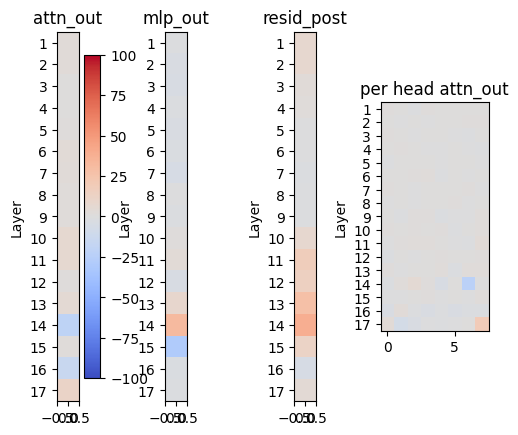

In [166]:
#plt.imshow(per_head_logit_attributions.detach().cpu()[1:,0], cmap="coolwarm",vmin=-100,vmax=100)
fig,axs = plt.subplots(1,4)

vmax = 100
im = axs[0].imshow((attn_out_logit_attributions).detach().cpu()[1:], cmap="coolwarm",vmin=-vmax,vmax=vmax)
axs[0].set_yticks(range(0,17),range(1,18))
axs[0].set_ylabel("Layer")
axs[0].set_title("attn_out")

axs[1].imshow((mlp_out_logit_attributions).detach().cpu()[1:], cmap="coolwarm",vmin=-vmax,vmax=vmax)
axs[1].set_yticks(range(0,17),range(1,18))
axs[1].set_ylabel("Layer")
axs[1].set_title("mlp_out")

axs[2].imshow((resid_post_logit_attributions).detach().cpu()[1:], cmap="coolwarm",vmin=-vmax,vmax=vmax)
axs[2].set_yticks(range(0,17),range(1,18))
axs[2].set_ylabel("Layer")
axs[2].set_title("resid_post")

axs[3].imshow((per_head_logit_attributions).detach().cpu()[1:,0], cmap="coolwarm",vmin=-vmax,vmax=vmax)
axs[3].set_yticks(range(0,17),range(1,18))
axs[3].set_ylabel("Layer")
axs[3].set_title("per head attn_out")


fig.colorbar(im)

In [142]:
attention_pattern = run_with_single_cache(model,"pattern", prompt)

In [143]:
print(attention_pattern.shape)

suffix = 200
layer = 14
pat = attention_pattern[layer,0,:,-suffix:,-suffix:]
pat[:,:,0] += attention_pattern[layer,0,:,-suffix:,:-suffix].sum(-1)
att_vis = cv.attention.attention_patterns(
    tokens=str_tokens[-suffix:],
    attention=pat,
    attention_head_names=[f"L{layer}H{i}" for i in range(8)],
)

path = "attn_heads.html"
with open(path, "w") as f:
    f.write(str(att_vis))

torch.Size([18, 1, 8, 961, 961])


In [171]:
df = pd.DataFrame(attention_pattern[layer,0,:,answer_token_idx].detach().cpu().T)
df["text"] = str_tokens
df = df.sort_values(6).loc[::-1]
df.loc[:10].style.background_gradient()

,0,1,2,3,4,5,6,7,text
761,0.162035,0.736312,0.038621,0.541372,0.571124,0.402833,0.883420,0.652601,","
544,0.001156,0.087207,0.000066,0.001216,0.024055,0.001502,0.171385,0.000398,*
743,0.001937,0.108795,0.000121,0.001609,0.059669,0.001578,0.164937,0.002378,*
100,0.000431,0.018184,0.000020,0.001141,0.009497,0.001335,0.089275,0.001200,-
168,0.001826,0.033516,0.000075,0.000744,0.071861,0.001088,0.076219,0.000706,+
870,0.021300,0.032662,0.001325,0.085074,0.240347,0.003859,0.051633,0.021038,-
374,0.000571,0.008812,0.000137,0.000761,0.007966,0.000527,0.048867,0.000466,-
0,0.067994,0.242636,0.003682,0.337840,0.048715,0.325469,0.034811,0.593908,
444,0.000567,0.024655,0.000013,0.000473,0.054460,0.000393,0.028165,0.000118,+
269,0.000633,0.006150,0.000026,0.000950,0.004636,0.000250,0.025704,0.000526,-
